In [23]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report



In [24]:
def read_csv_file(file_path):
    return pd.read_csv(file_path)

def preprocess_data(df):
    text = []
    journalist = []
    outcomes = []
    for i in range(len(df)):
        authors = df['Authors'][i]
        authors = authors.replace('[', '').replace(']', '').replace('"', '').replace('\'', '')
        authors = list(authors.split(','))
        check = df['Check'][i]
        pred = df['Title + Subtitle'][i]
        for author in list(authors):
            text.append(pred)
            journalist.append(author.strip())
            outcomes.append(check)

    processed_data = pd.DataFrame({'text': text, 'journalist': journalist, 'outcome':outcomes})
    processed_data = processed_data[processed_data['outcome'] != 'Uncertain']
    processed_data['outcome'].replace('Correct', 'positive', inplace=True) 
    processed_data['outcome'].replace('Incorrect', 'negative', inplace=True)
    
    return processed_data

desisionTreeTest = read_csv_file('/Users/benschlagman/Desktop/UCL Year 3/Final Year Project/Data/MLDatabase.csv')
data = preprocess_data(desisionTreeTest)

In [25]:
data

,text,journalist,outcome
1,Apple warns of iPhone shipment delays in wake ...,Ryan McMorrow,positive
2,Apple warns of iPhone shipment delays in wake ...,Nian Liu,positive
3,Apple warns of iPhone shipment delays in wake ...,Patrick McGee,positive
4,Apple warns of iPhone shipment delays in wake ...,Tabby Kinder,positive
7,Workers flee Covid restrictions at China’s lar...,Gloria Li,negative
...,...,...,...
9446,US tech warns Netherlands over tax regime Grou...,Vanessa Houlder,negative
9447,Nasdaq Composite nears all-time high String of...,Eric Platt,positive
9448,Netflix slides after net new subscriber number...,Adam Samson,negative
9450,Wall Street enjoys best week since late-2015 a...,Gregory Meyer,positive


In [6]:
def vectorize_predictions(data):
    tfidf = TfidfVectorizer(stop_words='english')
    X_text = tfidf.fit_transform(data['text'])
    return X_text

def create_dummy_vars(data):
    X_journalist = pd.get_dummies(data['journalist'], drop_first=True)
    X_journalist_matrix = csr_matrix(X_journalist)
    return X_journalist_matrix, X_journalist

def concatenate_data(X_text, X_journalist_matrix):
    X = hstack((X_text, X_journalist_matrix))
    return X

def get_target(data):
    y = data['outcome']
    y = y.to_numpy()
    return y

def split_data(X, y, data):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in gss.split(X.A, y, groups=data['text']):
        X_train = X.A[train_index, :]
        X_test = X.A[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test, train_index, test_index

def check_overlap(data, train_index, test_index):
    for group in data['text'].unique():
        train_group_mask = data['text'].iloc[train_index] == group
        test_group_mask = data['text'].iloc[test_index] == group
        if train_group_mask.any() and test_group_mask.any():
            print(f"Samples from group {group} are in both the training and test sets.")

def create_gb_classifier():
    gb = GradientBoostingClassifier()
    return gb

def create_gb_classifier_params_identfied():
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=5)
    return gb

def define_param_grid():
    param_grid = {'n_estimators': [100, 200, 300],
                  'learning_rate': [0.1, 0.05, 0.01],
                  'max_depth': [3, 4, 5]}
    return param_grid

def create_grid_search_object(gb, param_grid):
    return GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')

def fit_grid_search_object(CV, X_train, y_train):
    CV.fit(X_train, y_train)
    return CV

def get_best_params(CV):
    return CV.best_params_

def evaluate_model_accuracy(CV, X_test, y_test):
    accuracy = CV.score(X_test, y_test)
    return "Accuracy: {:.2f}%".format(accuracy * 100)



In [21]:
#Fine Tuning the models hyperparamters 

# vectorize the 'text' column
X_text = vectorize_predictions(data)
# create dummy variables for the 'journalist' column
X_journalist_matrix, X_journalist = create_dummy_vars(data)
# concatenate the text and journalist data
X = concatenate_data(X_text, X_journalist_matrix)
# get the target values
y = get_target(data)
# split the data into training and testing sets
X_train, X_test, y_train, y_test, train_index, test_index = split_data(X, y, data)
# check for overlap between the training and testing sets
check_overlap(data, train_index, test_index)
# create a gradient boosting classifier
gb = create_gb_classifier()
# define the parameter grid for grid search
param_grid = define_param_grid()
# create a grid search object
CV = create_grid_search_object(gb, param_grid)
# fit the grid search object to the training data
CV = fit_grid_search_object(CV, X_train, y_train)
# get the best parameters from the grid search
best_params = get_best_params(CV)
print("Best parabmeters:", best_params)
# evaluate the model's accuracy on the test data
accuracy = evaluate_model_accuracy(CV, X_test, y_test)
print(accuracy)

KeyboardInterrupt: 

In [26]:
# Using the hyperparamters to train the model

# vectorize the 'text' column
X_text = vectorize_predictions(data)
# create dummy variables for the 'journalist' column
X_journalist_matrix, X_journalist = create_dummy_vars(data)
# concatenate the text and journalist data
X = concatenate_data(X_text, X_journalist_matrix)
# get the target values
y = get_target(data)
# split the data into training and testing sets
X_train, X_test, y_train, y_test, train_index, test_index = split_data(X, y, data)
# check for overlap between the training and testing sets
check_overlap(data, train_index, test_index)
# create a gradient boosting classifier
gb = create_gb_classifier_params_identfied()
# fit the grid search object to the training data
CV = fit_grid_search_object(gb, X_train, y_train)
# evaluate the model's accuracy on the test data
accuracy = evaluate_model_accuracy(CV, X_test, y_test)
print(accuracy)


Accuracy: 58.76%


Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.85      0.70       483
    positive       0.56      0.25      0.35       373

    accuracy                           0.59       856
   macro avg       0.58      0.55      0.52       856
weighted avg       0.58      0.59      0.55       856



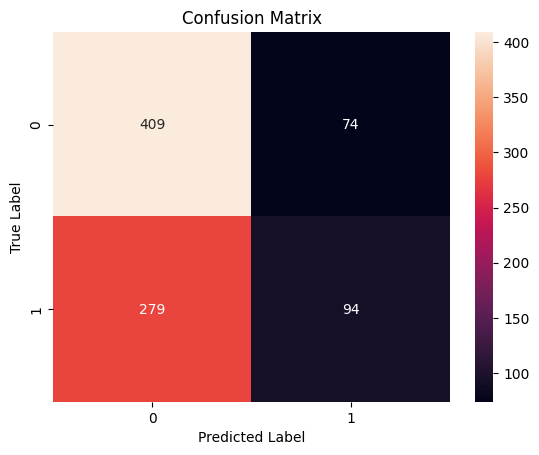

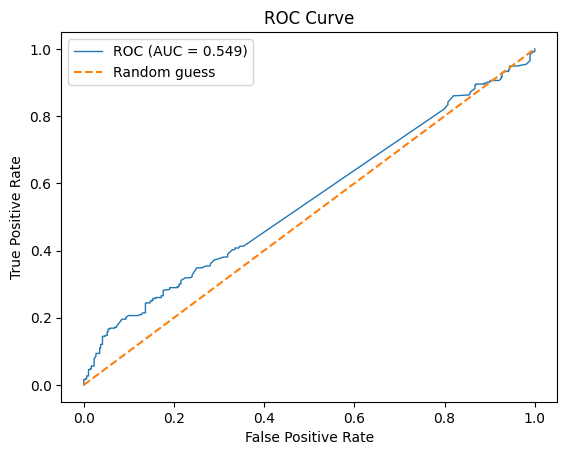

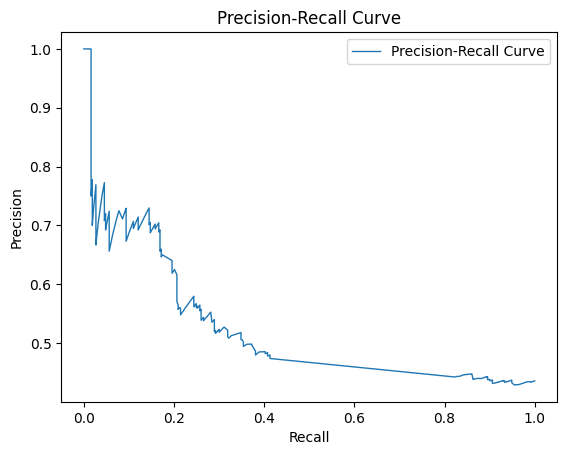

In [27]:
## Plot visualisation techniques

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_test, y_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1], pos_label='positive')
    roc_auc = roc_auc_score(y_test, y_probs[:, 1])
    plt.plot(fpr, tpr, lw=1, label='ROC (AUC = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_test, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:, 1], pos_label='positive')
    plt.plot(recall, precision, lw=1, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
def print_classification_report(y_test, y_pred):
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    

y_pred = gb.predict(X_test)
y_probs = gb.predict_proba(X_test)

print_classification_report(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_probs)
plot_precision_recall_curve(y_test, y_probs)


In [28]:
## Feature Importance

def get_journalist_feature_importance(model, X_journalist):
    journalist_feature_importance = model.feature_importances_[-X_journalist.shape[1]:]
    return journalist_feature_importance

def create_feature_mapping(X_journalist):
    feature_mapping = {i:col for i,col in enumerate(X_journalist.columns)}
    return feature_mapping

def create_importance_dict(journalist_feature_importance, feature_mapping):
    importance_dict = {feature_mapping[i]:journalist_feature_importance[i] for i in range(len(journalist_feature_importance))}
    return importance_dict

def sort_importance(importance_dict):
    sorted_importance = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}
    return sorted_importance

def print_importance(sorted_importance):
    print(sorted_importance)

journalist_feature_importance = get_journalist_feature_importance(gb, X_journalist)
feature_mapping = create_feature_mapping(X_journalist)
importance_dict = create_importance_dict(journalist_feature_importance, feature_mapping)
sorted_importance = sort_importance(importance_dict)
print_importance(sorted_importance)


{'David Crow': 0.002132066675301989, 'Lindsay Whipp': 0.0009791645645472072, 'Henry Sanderson': 0.000675671178998212, 'Alistair Gray': 0.00029545160680283374, 'Christopher Adams': 0.0002683214863048729, 'Robert Cookson': 0.0002632424842943537, 'Tom Hancock': 0.00026204695978519527, 'Dave Lee': 0.0002573013003983471, 'Christian Shepherd': 0.0002327434678093346, 'Mamta Badkar': 0.00022886604567246528, 'Hannah Murphy': 0.00013568410991698327, 'Neil Buckley': 0.00013192833027723407, 'Ed Crooks': 0.00013020699557994214, 'Sarah Gordon': 0.00012606918415783826, 'Richard Waters': 0.00012565449034489723, 'Bryce Elder': 0.0001225164521783388, 'Chris Nuttall': 1.1289542276598511e-05, 'Anna Nicolaou': 3.974163547994312e-06, 'Pan Kwan Yuk': 3.8034801652169993e-06, 'Shunsuke Tabeta': 1.0618820660806599e-06, 'Laura Noonan': 5.063089764876914e-07, 'Ben McLannahan': 2.9264008188054065e-07, 'Alex Barker': 1.2798313178203655e-07, 'Patrick McGee': 1.0131248651046254e-07, 'Andrew Ward': 8.320463118422794e-

In [19]:
def fit_new_model(X_text, X_journalist, y, sorted_importance, n=15):
    top_features = [feature for feature, importance in sorted_importance.items() if importance >= sorted(journalist_feature_importance, reverse=True)[n]]
    X_top_features = X_journalist[top_features]
    X_top_features_matrix = csr_matrix(X_top_features)
    X_new = hstack((X_text, X_top_features_matrix))
    X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    gb_new = GradientBoostingClassifier()
    gb_new.fit(X_train_new, y_train)
    accuracy = gb_new.score(X_test_new, y_test)
    print("Accuracy of the new model: {:.2f}%".format(accuracy * 100))
    return gb_new, X_test_new, X_test_new

gb_new, X_test_new, X_test_new = fit_new_model(X_text, X_journalist, y, sorted_importance)

Accuracy of the new model: 61.68%


In [29]:

# select the top n features based on feature importance scores
n = 15
top_features = [feature for feature, importance in sorted_importance.items() if importance >= sorted(journalist_feature_importance, reverse=True)[n]]

# create a new dataframe with only the top features
X_top_features = X_journalist[top_features]

# concatenate the text and journalist data
X_top_features_matrix = csr_matrix(X_top_features)
X_new = hstack((X_text, X_top_features_matrix))

# split the data into training and test sets
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# create a new GradientBoostingClassifier object
gb_new = GradientBoostingClassifier()

# fit the new model on the training data
gb_new.fit(X_train_new, y_train)

# evaluate the new model on the test data
accuracy = gb_new.score(X_test_new, y_test)
print("Accuracy of the new model: {:.2f}%".format(accuracy * 100))


Accuracy of the new model: 61.68%


Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.86      0.71       455
    positive       0.69      0.34      0.45       401

    accuracy                           0.62       856
   macro avg       0.64      0.60      0.58       856
weighted avg       0.64      0.62      0.59       856



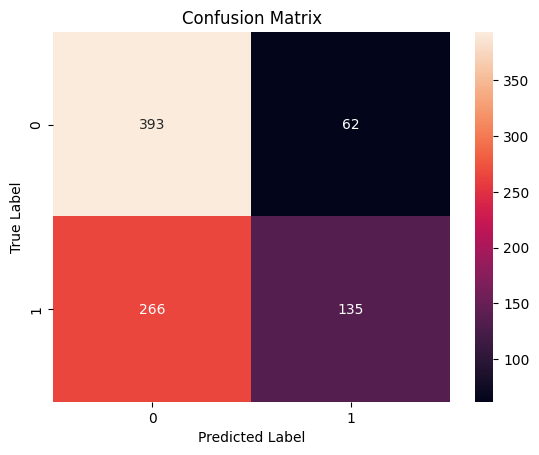

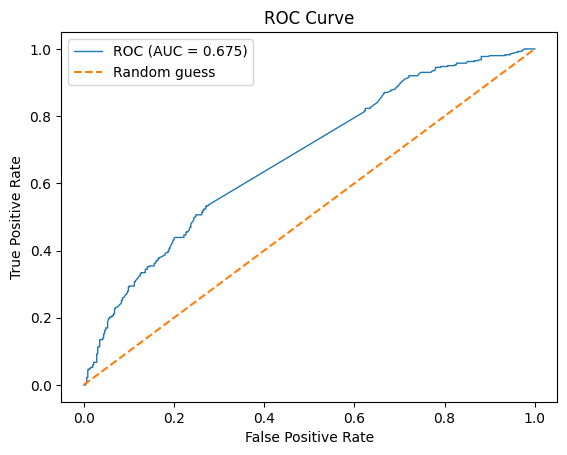

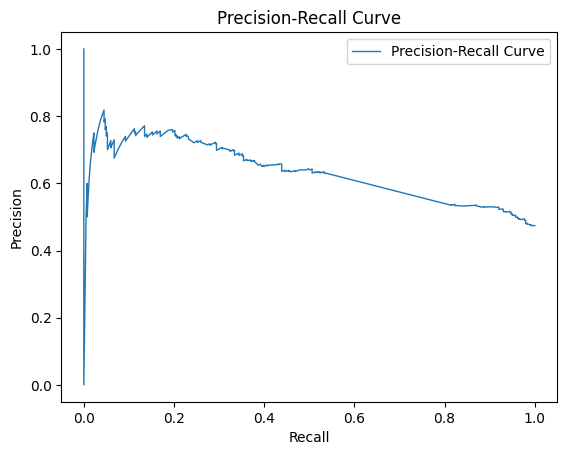

In [30]:
y_pred = gb_new.predict(X_test_new)
y_probs = gb_new.predict_proba(X_test_new)

print_classification_report(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_probs)
plot_precision_recall_curve(y_test, y_probs)
